___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Session - 10 Part -1<br><br>Univariate Time Series Forecasting with RNN<br><br>RSCCASN<br><h1>

# RNN (Time Series)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('RSCCASN.csv',
                 index_col='DATE',
                 parse_dates=True  # datetimeIndex type'a çevirmek için kullanıyoruz
                )

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

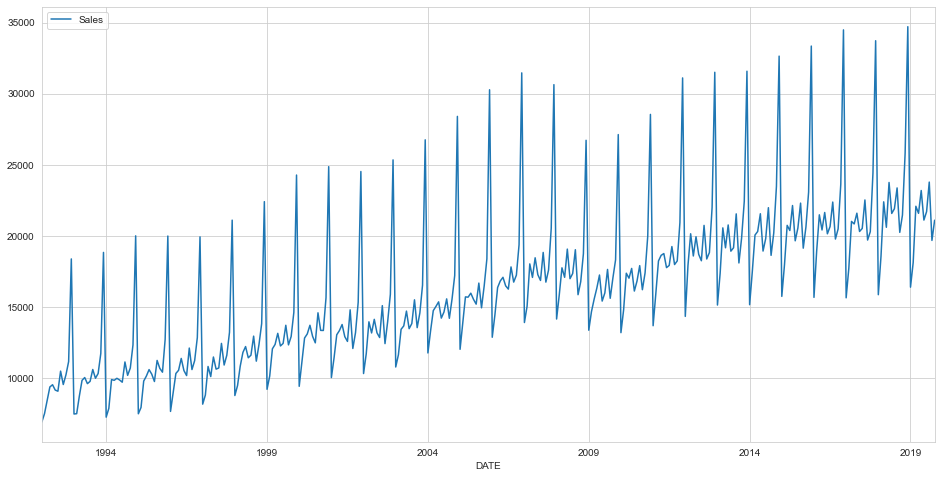

In [6]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [7]:
len(df)

334

In [8]:
# burada periyodumuz 12 (12 ay); testsize'ı belirlediğimiz periyottan fazla almamız gerekiyordu
test_size = 24

In [9]:
test_ind = len(df)- test_size
test_ind

310

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
# sequence olduğu için test datasını sondan alıyoruz

In [ ]:
# HATIRLATMA: uzun sequence'lar kullanılarak eğitilen modellerde iyi tahminler alınamaz (short memory)

In [11]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-06-01,20322
2017-07-01,20535
2017-08-01,22536


In [12]:
test

,Sales
DATE,
2017-11-01,24438
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


### Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
# tek feature ile çalıştığımızdan y_train, y_test kullanmıyoruz

## Time Series Generator

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
# help(TimeseriesGenerator)

In [18]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=length, batch_size=batch_size)

In [19]:
len(generator)

298

In [20]:
generator[0]
# 12 data verilecek, 13.'yü tahmin edecek

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [21]:
X, y = generator[0]

In [22]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


## Modeling

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [24]:
n_features = train_scaled.shape[1]  # 1

In [25]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape=(length, n_features)))
# return_sequences=True ====> birden fazla katman kullandığımız için, diğer katmana tek çıktı (output) değil, sequence halinde 
# datayı göndermesi için kullanıyoruz
model.add(LSTM(50, activation = 'tanh'))  # default activation function is 'tanh' for LSTM
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

# activation function olarak 'relu' da denenebilir; burada 'relu' daha iyi sonuç veriyor, biz default function'ı kullandık

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [27]:
# params = 4 * ((size_of_input + 1) * size_of_output + size_of_output^2)
4 * ((1+1)*100+(100**2))

40800

In [28]:
4 * ((100+1)*50+(50**2))

30200

### EarlyStopping and Validation Generator

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [31]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [32]:
len(validation_generator)

12

In [33]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
298/298 [==============================] - 10s 16ms/step - loss: 0.0215 - val_loss: 0.0312
Epoch 2/20
298/298 [==============================] - 4s 13ms/step - loss: 0.0185 - val_loss: 0.0291
Epoch 3/20
298/298 [==============================] - 4s 14ms/step - loss: 0.0189 - val_loss: 0.0243
Epoch 4/20
298/298 [==============================] - 4s 15ms/step - loss: 0.0163 - val_loss: 0.0220
Epoch 5/20
298/298 [==============================] - 4s 12ms/step - loss: 0.0159 - val_loss: 0.0227
Epoch 6/20
298/298 [==============================] - 4s 13ms/step - loss: 0.0159 - val_loss: 0.0206
Epoch 7/20
298/298 [==============================] - 4s 12ms/step - loss: 0.0157 - val_loss: 0.0237
Epoch 8/20
298/298 [==============================] - 4s 13ms/step - loss: 0.0156 - val_loss: 0.0257
Epoch 9/20
298/298 [==============================] - 4s 12ms/step - loss: 0.0120 - val_loss: 0.0192
Epoch 10/20
298/298 [==============================] - 4s 12ms/step - loss: 0.0105 - val_l

<AxesSubplot:>

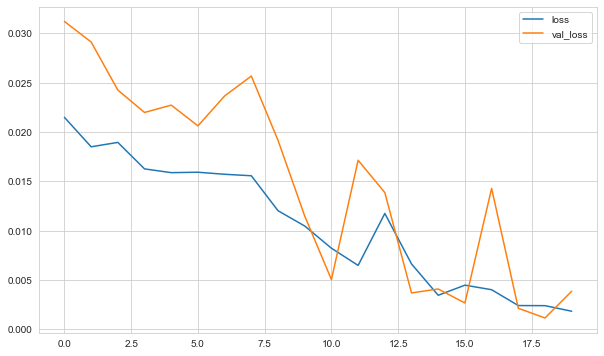

In [34]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

## Evaluate on Test Data

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [36]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [37]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features)) # boyut sayısını artırıyoruz

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [38]:
current_pred  # iki boyutlu

array([[0.48889172]], dtype=float32)

In [39]:
current_batch  # üç boyutlu

array([[[0.59926963],
        [0.83697951],
        [0.34837085],
        [0.42692354],
        [0.5072518 ],
        [0.50560266],
        [0.5141626 ],
        [0.48246169],
        [0.49380937],
        [0.51867878],
        [0.45373675],
        [0.48889172]]])

In [40]:
predictions_scaled

[array([0.5992696], dtype=float32),
 array([0.8369795], dtype=float32),
 array([0.34837085], dtype=float32),
 array([0.42692354], dtype=float32),
 array([0.5072518], dtype=float32),
 array([0.50560266], dtype=float32),
 array([0.5141626], dtype=float32),
 array([0.4824617], dtype=float32),
 array([0.49380937], dtype=float32),
 array([0.5186788], dtype=float32),
 array([0.45373675], dtype=float32),
 array([0.48889172], dtype=float32)]

In [41]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.8266768198080904 
mae: 0.050478285282593495 
mse: 0.0038386622109884533 
rmse: 0.06195693836035197


### Inverse Transformations and Comparing

In [42]:
predictions = scaler.inverse_transform(predictions_scaled)  # unscale

In [43]:
compare = test[:12]  # bu zaten scale edilmemiş haliydi

In [44]:
compare['Predictions'] = predictions

In [45]:
compare

,Sales,Predictions
DATE,,
2017-11-01,24438,23444.283
2017-12-01,33720,29991.764
2018-01-01,15881,16533.527
2018-02-01,18585,18697.182
2018-03-01,22404,20909.744
2018-04-01,20616,20864.320
2018-05-01,23764,21100.095
2018-06-01,21589,20226.925
2018-07-01,21919,20539.485


<AxesSubplot:xlabel='DATE'>

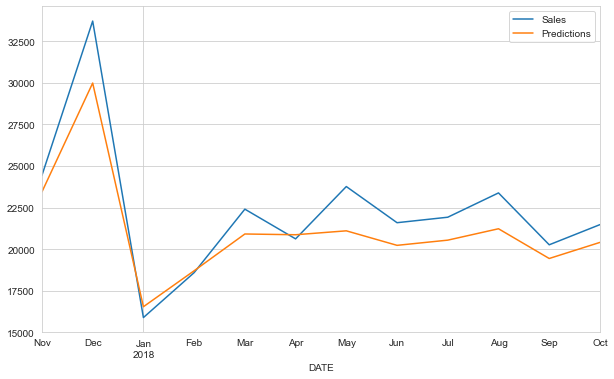

In [46]:
compare.plot()  # 12 aylık prediction

In [47]:
eval_metrics(compare.Sales, compare.Predictions)  # scale edilmemiş datayla skor almış olduk

r2_score: 0.8266768198080899 
mae: 1390.3738898237564 
mse: 2912285.2912606574 
rmse: 1706.5419101975367


## Retrain and Forecasting

In [48]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [49]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [50]:
len(df)

334

In [51]:
len(generator)

322

In [52]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=20)

# elimizde validation data olmadığından early stop kullanmadık

Epoch 1/20
322/322 [==============================] - 9s 12ms/step - loss: 0.0226
Epoch 2/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0211
Epoch 3/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0181
Epoch 4/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0182
Epoch 5/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0185
Epoch 6/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0165
Epoch 7/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0159
Epoch 8/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0146
Epoch 9/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0144
Epoch 10/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0137
Epoch 11/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0125
Epoch 12/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0117
Epoch 13/20
3

In [53]:
scaled_full_data.shape

(334, 1)

In [54]:
scaled_full_data[-length:].shape

(12, 1)

In [55]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [56]:
forecast = scaler.inverse_transform(forecast)

In [57]:
forecast

array([[24215.48337603],
       [28337.88070869],
       [17721.51529694],
       [19583.4391284 ],
       [21759.62845087],
       [21642.07091808],
       [22221.04894972],
       [21180.30236816],
       [21742.84976244],
       [22100.163589  ],
       [19808.02893257],
       [21228.81609058]])

In [58]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [59]:
forecast_index = pd.date_range(start = '2019-11-01', periods = length, freq = 'MS')
# data indeksi 2019-10. ayda bittiği için kaldığı yerden devam edecek şekilde indeksliyoruz
# MS ===> month start frequency

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

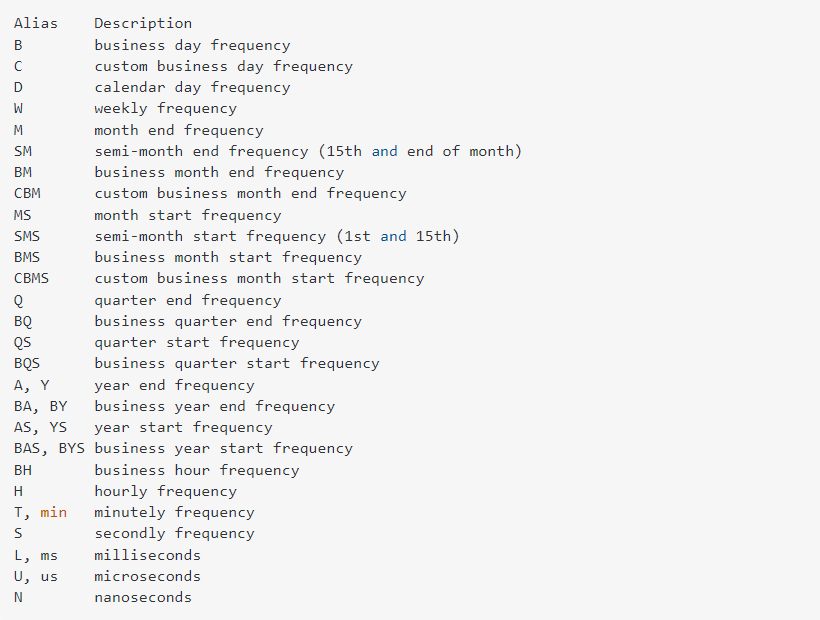

In [60]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [61]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [62]:
forecast_df

,Forecast
2019-11-01,24215.483
2019-12-01,28337.881
2020-01-01,17721.515
2020-02-01,19583.439
2020-03-01,21759.628
2020-04-01,21642.071
2020-05-01,22221.049
2020-06-01,21180.302
2020-07-01,21742.850
2020-08-01,22100.164


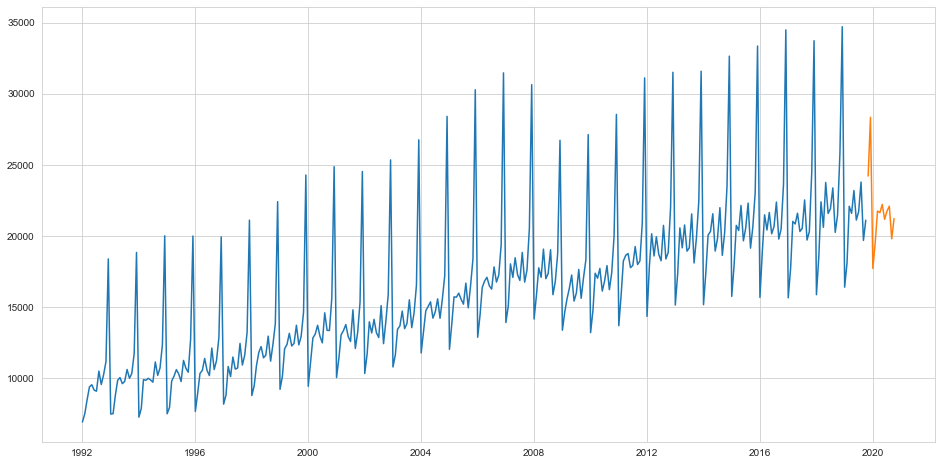

In [63]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

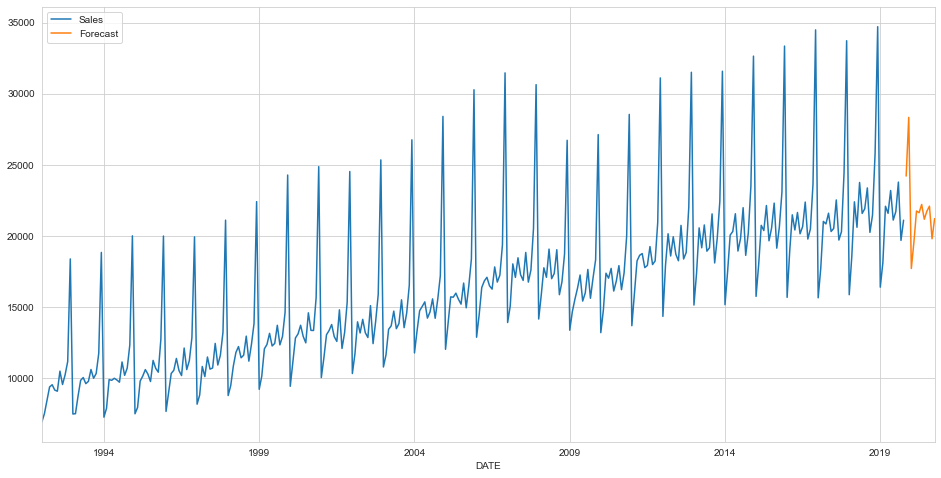

In [64]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));
# yukarıdakinin aynısı ama bu şekilde gösterirsek alttaki gibi belli bir dilimi de gösterebiliyoruz

(576.0, 611.0)

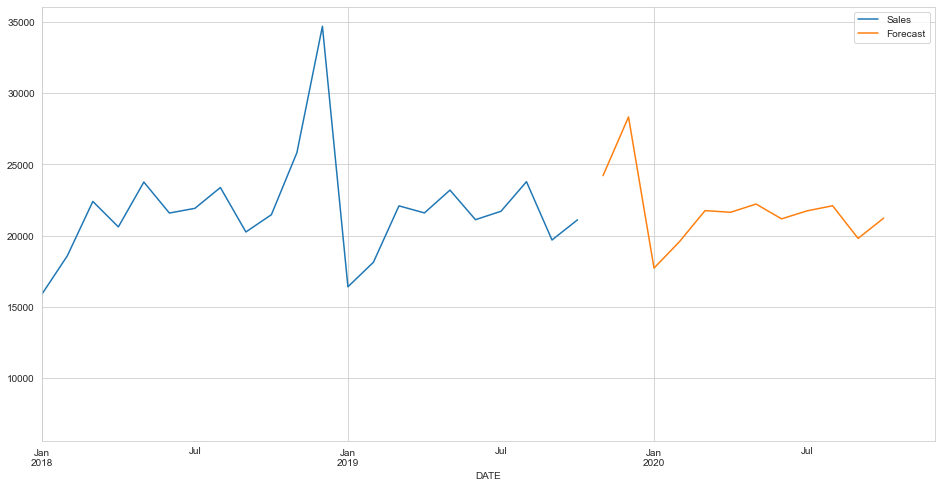

In [65]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')
# dataframe'leri birleştirseydik arada kopukluk olmazdı, ama o zaman da renk ayrımı olmazdı

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___